## whole

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

In [2]:
import pickle
with open('structured_abstract_sections.pkl', 'rb') as f:
    normalized_sections = pickle.load(f)

sentences = []
indices = []
for normal_sect in normalized_sections:
    print(f'{normal_sect}: {len(normalized_sections[normal_sect])}')
    index = [len(sentences)]
    sentences += [text.lower() for text in normalized_sections[normal_sect]]
    index.append(len(sentences))
    indices.append(index)
    
print(indices)

methods: 1492
background: 215
results: 314
conclusions: 488
objective: 523
[[0, 1492], [1492, 1707], [1707, 2021], [2021, 2509], [2509, 3032]]


In [3]:

from collections import defaultdict
from tqdm import tqdm
fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)

import numpy as np
# np.save("embeddings_lower_test.npy", embeddings)

# 读取 embeddings
# loaded_embeddings = np.load("embeddings_lower.npy")


In [4]:
averages = []
for start, end in indices:
    embedding = embeddings[start:end]
    averages.append(np.mean(embedding, axis=0))

In [5]:
averages = np.array(averages)
np.save("averages_lower.npy", averages)

In [6]:
print(averages)

[[ 0.03558871  0.03356181 -0.06619266 ...  0.10495782  0.01723036
   0.0366231 ]
 [-0.13124542  0.07400809 -0.09880937 ...  0.03050551 -0.00203388
   0.02440936]
 [-0.07807221  0.11255819 -0.10282388 ...  0.00877835  0.00285315
  -0.00887733]
 [-0.09178653  0.079993   -0.07731932 ...  0.05086267  0.01297714
  -0.02654091]
 [-0.07913794  0.06918538 -0.09001073 ...  0.09340516 -0.0497851
   0.01945007]]


## test

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

In [2]:
import pickle
import numpy as np
with open('structured_abstract_sections.pkl', 'rb') as f:
    normalized_sections = pickle.load(f)

sentences = []
indices = []
for normal_sect in normalized_sections:
    print(f'{normal_sect}: {len(normalized_sections[normal_sect])}')
    index = [len(sentences)]
    sentences += [text.lower() for text in normalized_sections[normal_sect]]
    index.append(len(sentences))
    indices.append(index)
    
labels = np.zeros(indices[-1][1], dtype=int)  # 創建一個與最大索引一致的 0 陣列

# 根據 indices 填充標籤
for i, (start, end) in enumerate(indices):
    labels[start:end] = i


methods: 1492
background: 215
results: 314
conclusions: 488
objective: 523


In [3]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_test_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


In [4]:
from sklearn.model_selection import train_test_split

num_samples = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
num_classes = 5

indices = np.arange(len(labels))  # 生成原始数据的索引

train_embeddings, test_embeddings, train_labels, test_labels, train_indices, test_indices = train_test_split(
    embeddings, labels, indices, test_size=0.1, random_state=42, shuffle=True, stratify=labels
)

In [11]:
import pandas as pd

df = pd.read_csv('result_on_NLM.csv')
df

,Unnamed: 0,True Label,Predicted_average,Predicted_supervised
0,0,methods,methods,methods
1,1,results,results,results
2,2,objective,objective,objective
3,3,conclusions,conclusions,conclusions
4,4,methods,results,results
...,...,...,...,...
299,299,objective,objective,objective
300,300,conclusions,conclusions,conclusions
301,301,objective,objective,objective
302,302,background,background,background


In [12]:
df['actual heading'] = [sentences[i] for i in test_indices]
df

,Unnamed: 0,True Label,Predicted_average,Predicted_supervised,actual heading
0,0,methods,methods,methods,place and duration
1,1,results,results,results,main outcome
2,2,objective,objective,objective,objective and methods
3,3,conclusions,conclusions,conclusions,mini-abstract
4,4,methods,results,results,outcomes of interest
...,...,...,...,...,...
299,299,objective,objective,objective,the aim of study
300,300,conclusions,conclusions,conclusions,conclusion/implications
301,301,objective,objective,objective,study aims
302,302,background,background,background,availability and supplementary information


In [13]:
df.to_csv('result_on_NLM.csv')

In [5]:
averages = []
for i in range(5):
    mask = train_labels == i
    averages.append(np.mean(train_embeddings[mask], axis=0))

In [7]:
np.save('average_model/average_lower_test.npy', averages)

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.8
similarity_matrix = cosine_similarity(test_embeddings, averages)
predicted_averages = np.argmax(similarity_matrix, axis=1)
print("Predicted labels:", predicted_averages)

Predicted labels: [0 2 4 3 0 3 3 0 3 0 0 0 3 0 1 3 0 0 3 0 0 0 2 0 4 1 1 0 3 4 1 2 2 3 4 0 4
 0 0 0 1 0 3 0 0 3 0 2 2 0 4 0 3 3 0 4 3 3 1 0 0 0 2 0 1 0 2 3 3 4 0 1 0 2
 0 0 2 3 0 0 0 0 2 3 0 0 0 3 4 3 1 3 1 0 0 3 2 4 0 0 1 2 4 3 4 0 2 0 3 0 0
 2 0 0 0 0 1 0 2 3 0 2 4 3 0 0 2 0 0 4 4 0 0 4 4 0 4 0 0 0 0 4 0 0 0 0 4 1
 0 4 0 0 3 0 0 0 3 3 0 2 0 4 3 2 0 3 0 0 0 1 0 0 3 0 0 4 0 2 0 1 0 3 2 0 2
 2 4 0 0 4 1 4 3 0 1 1 0 0 0 4 0 0 1 0 0 3 0 3 1 0 0 0 0 4 2 3 0 3 0 1 4 0
 0 1 0 0 0 0 1 0 4 0 4 1 4 0 4 3 0 0 4 3 3 0 0 4 0 2 0 0 3 0 3 4 0 2 0 0 0
 3 0 0 0 0 0 4 4 4 3 0 3 3 0 0 0 3 4 3 4 0 0 4 0 0 0 0 0 3 2 3 0 0 0 0 2 0
 1 2 4 4 3 4 1 0]


In [9]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test)

acc = get_acc(predicted_averages, test_labels)
average = 'macro'
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(test_labels, predicted_averages, average=average)  # 二分类
recall = recall_score(test_labels, predicted_averages, average=average)
f1 = f1_score(test_labels, predicted_averages, average=average)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.8865
Recall: 0.8976
F1-score: 0.8896
accuracy: 0.9178


In [10]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_averages, digits=4))


              precision    recall  f1-score   support

           0     0.9467    0.9467    0.9467       150
           1     0.7692    0.9091    0.8333        22
           2     0.8333    0.8065    0.8197        31
           3     0.9057    0.9796    0.9412        49
           4     0.9778    0.8462    0.9072        52

    accuracy                         0.9178       304
   macro avg     0.8865    0.8976    0.8896       304
weighted avg     0.9210    0.9178    0.9179       304



In [11]:
mapping = {
    -1: 'None',
    0:'methods',
    1:'background',
    2:'results',
    3:'conclusions',
    4:'objective',
}

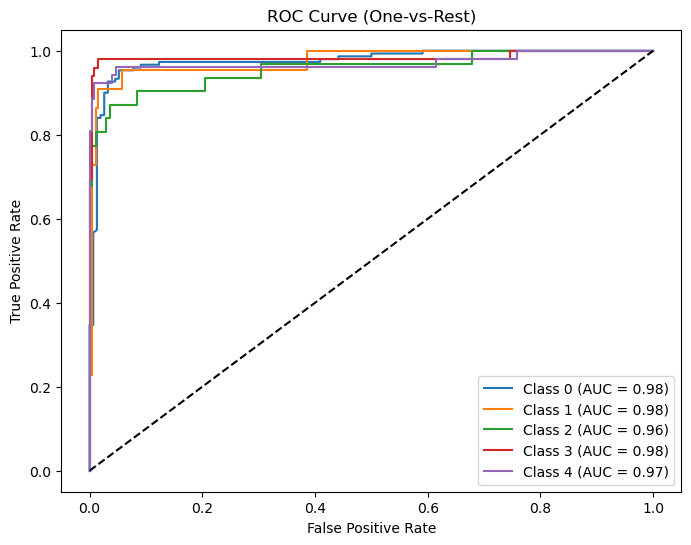

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 假設 test_labels 和 predicted_averages 是數值類別
num_classes = len(np.unique(test_labels))

# One-hot 編碼
y_test_bin = label_binarize(test_labels, classes=np.arange(num_classes))
y_score = similarity_matrix  # 這裡的 similarity_matrix 作為分數

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# 繪製對角線
plt.plot([0, 1], [0, 1], 'k--')

# 設定標題和標籤
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")

plt.show()


In [49]:
precision_per_label = precision_score(test_labels, predicted_averages, average=None)
recall_per_label = recall_score(test_labels, predicted_averages, average=None)
f1_per_label = f1_score(test_labels, predicted_averages, average=None)

# 输出整体 performance
print(f"Overall Accuracy: {acc:.4f}")
print("\nPer-label Performance:")
for i, (p, r, f1) in enumerate(zip(precision_per_label, recall_per_label, f1_per_label)):
    print(f"Label {mapping[i]}: Precision={p:.4f}, Recall={r:.4f}, F1-score={f1:.4f}")

Overall Accuracy: 0.9112

Per-label Performance:
Label methods: Precision=0.9456, Recall=0.9267, F1-score=0.9360
Label background: Precision=0.7692, Recall=0.9091, F1-score=0.8333
Label results: Precision=0.8000, Recall=0.7742, F1-score=0.7869
Label conclusions: Precision=0.9057, Recall=0.9796, F1-score=0.9412
Label objective: Precision=0.9583, Recall=0.8846, F1-score=0.9200


In [50]:

import pandas as pd
df = pd.DataFrame({'True Label': [mapping[i] for i in test_labels], 'Predicted_average': [mapping[i] for i in predicted_averages]})
df

,True Label,Predicted_average
0,methods,methods
1,results,results
2,objective,objective
3,conclusions,conclusions
4,methods,results
...,...,...
299,objective,objective
300,conclusions,conclusions
301,objective,objective
302,background,background


In [51]:
df['True Label'].value_counts()

True Label
methods        150
objective       52
conclusions     49
results         31
background      22
Name: count, dtype: int64

In [52]:
df.to_csv('result_on_NLM.csv')

## val

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

In [26]:
import pickle
import numpy as np
with open('structured_abstract_sections.pkl', 'rb') as f:
    normalized_sections = pickle.load(f)

sentences = []
indices = []
for normal_sect in normalized_sections:
    print(f'{normal_sect}: {len(normalized_sections[normal_sect])}')
    index = [len(sentences)]
    sentences += [text.lower() for text in normalized_sections[normal_sect]]
    index.append(len(sentences))
    indices.append(index)
    
labels = np.zeros(indices[-1][1], dtype=int)  # 創建一個與最大索引一致的 0 陣列

# 根據 indices 填充標籤
for i, (start, end) in enumerate(indices):
    labels[start:end] = i


methods: 1492
background: 215
results: 314
conclusions: 488
objective: 523


In [27]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss_val_lower")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


In [28]:
from sklearn.model_selection import train_test_split

num_samples = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
num_classes = 5

train_val_embeddings, test_embeddings, train_val_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42, shuffle=True, stratify=labels
)

train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
    train_val_embeddings, train_val_labels, test_size=1/9, random_state=42, shuffle=True, stratify=train_val_labels
)
print("methods, background, results, conclusions, objective")
print("Train labels distribution:", np.bincount(train_labels))
print("Validation labels distribution:", np.bincount(val_labels))
print("Test labels distribution:", np.bincount(test_labels))

methods, background, results, conclusions, objective
Train labels distribution: [1192  172  251  390  419]
Validation labels distribution: [150  21  32  49  52]
Test labels distribution: [150  22  31  49  52]


In [29]:
averages = []
for i in range(5):
    mask = train_labels == i
    averages.append(np.mean(train_embeddings[mask], axis=0))

In [30]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.95
similarity_matrix = cosine_similarity(val_embeddings, averages)
max_sim_indices = np.argmax(similarity_matrix, axis=1)
max_sim_values = np.max(similarity_matrix, axis=1)
predicted_averages = np.where(max_sim_values >= threshold, max_sim_indices, -1)
print("Predicted labels:", predicted_averages)

Predicted labels: [ 0  0  3  0  2  0  0  3  2  0  2  4  3  3  0  4  0  0  0  0  3  0  2  0
  1  4  0  0  3  0  3  1  2  0  0  3  0  0  0  0  3  4  2  0  3  0  4  2
  0  3  3  0  4  2  0  0  4  0  0  0 -1  4  0  0  0  0  0  1  2  3  0  4
  4  2  0  0  4  4  0  0  4  3  3  0  0  2  0  3  0  1  1  3  0  4  0  0
  2  0  0  4  4  0  3  0  2  0  0  0  0  4  1  0  0  4  4  0  1  1  4  0
  2  3  0  0  0 -1  3  4  2  4  0  0  3  0  0  4  0  1  4  0  4  1  3  0
  0  0  0  0  4  0  0  4  0  0  3  0  4  0  4  4  3  0  4  3  0  0  0  3
  0  4  1  0  2  0 -1  4  0  0  0  4  4  4  0  0  4  0  1  0  0  3  3  3
  0  0  4  4  0  0  4  0  0  4  4  0  0  4  4  0  3 -1  0  0  0  4  2  0
  0  0  1  0 -1  0  0  1  0  0  4  3  0  2  2  0  3  0  1  3  3  0  4  1
  2  3  2  0  3  0  0  4  0  2  0  0  0  0  0 -1  0  2 -1  3  2  0  3 -1
  0  0  4  0  2 -1  3  0  0  2  4  0  0 -1  3  0  4  0  2  2  2  0  3  0
  0  1  3  3  0  0  0  0  0  0  4  0  3  0  4  4]


In [31]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test)

acc = get_acc(predicted_averages, val_labels)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(val_labels, predicted_averages, average='macro')  # 二分类
recall = recall_score(val_labels, predicted_averages, average='macro')
f1 = f1_score(val_labels, predicted_averages, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"accuracy: {acc:.4f}")


Precision: 0.7780
Recall: 0.7269
F1-score: 0.7502
accuracy: 0.9276


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
